# Evaluation of text-to-image generation model with DSG

based on [Davidsonian Scene Graph: Improving Reliability in Fine-grained Evaluation for Text-to-Image Generation](https://google.github.io/dsg/) (ICLR 2024)

We provide the step-by-step walkthrough of text-to-image evaluation with DSG

1) Load example image & text
2) Generate DSG questions with LLM
3) Answer questions with VQA + Average scores with DSG question dependency 

and a single method for end-to-end evaluation which is compatible with any LLM and VQA models.

## 1) Load example image & text

In [9]:
from PIL import Image
from pprint import pprint

In [8]:
# INPUT_TEXT_PROMPT = "This is a black and white photograph capturing a dynamic scene at a skatepark. At the heart of the image is a skateboarder, dressed in a casual t-shirt and shorts, executing a daring trick. The skateboarder is perfectly balanced on the skateboard with one foot, while the other foot is suspended in mid-air, adding to the sense of motion in the image.\n\nThe skateboarder's shadow, sharply defined, stretches out on the ground beneath him, mirroring his airborne pose. This not only adds depth to the image but also emphasizes the bright outdoor lighting conditions.\n\nIn the background, other people can be seen, adding life and context to the scene. They are likely fellow skaters or spectators, their presence suggesting this is a shared and social space.\n\nA ramp is visible too, its curve echoing the arcs of movement made by the skaters. Its presence indicates that this is a well-equipped skatepark designed for tricks and stunts like the one being performed by the skateboarder.\n\nDespite being a still image, it's filled with energy and movement, perfectly encapsulating a moment of skill and daring in the vibrant world of skateboarding. The black and white color scheme enhances the contrast and drama of the scene."
INPUT_TEXT_PROMPT = "A baby is sleeping on a covered mattress. His shirt is black white and blue. The mattress cover has designs all over it. There is a doll with a blue and purple hoody nearby."


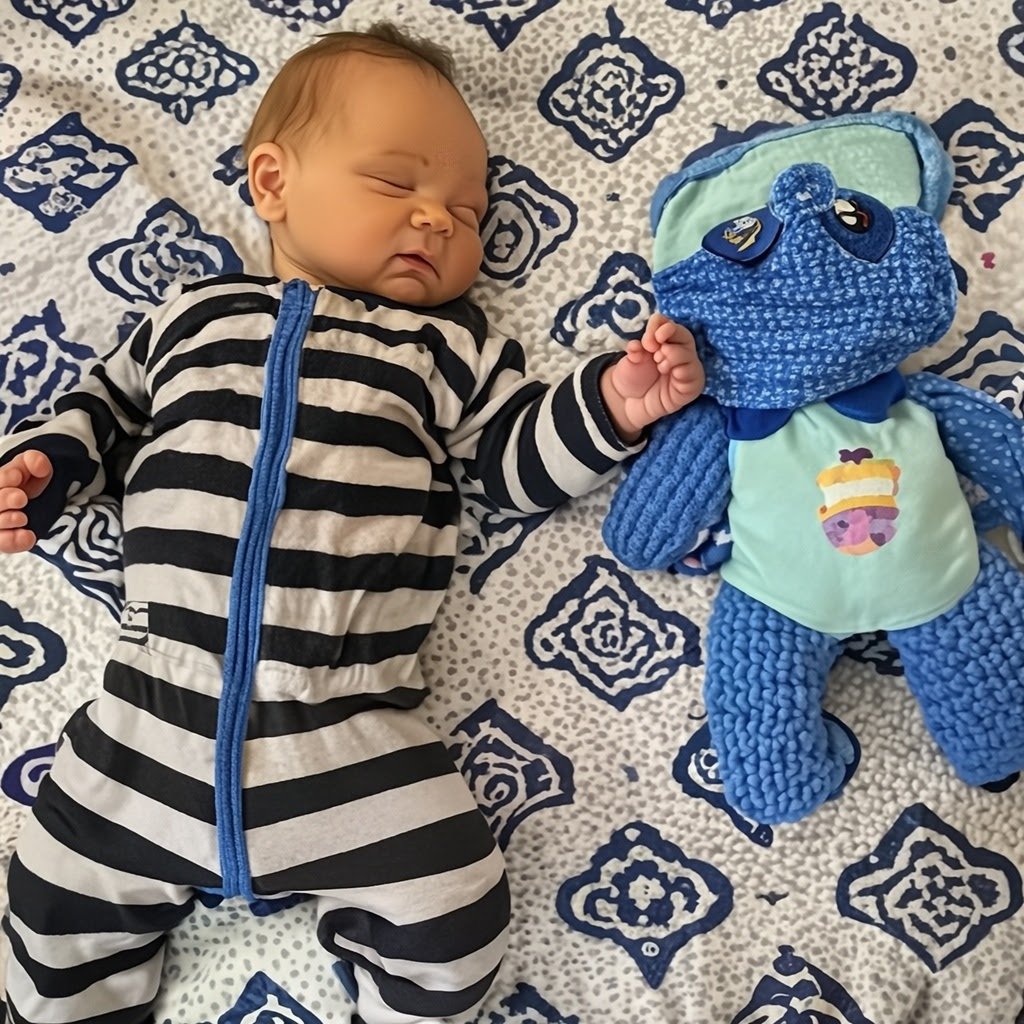

In [4]:
generated_image = Image.open("assets/example_img.png")
generated_image

# 2) Generate DSG with LLM

For example, we use gpt-3.5-turbo-16k-0613 (https://platform.openai.com/docs/models/gpt-3-5).

In [10]:
import openai
from dsg.openai_utils import openai_setup, openai_completion

# Reading API KEY from _OAI_KEY.txt
openai_setup()

# You can manually set OpenAI API key below
# openai.api_key = ""

assert openai.api_key is not None

# Run example LLM call
openai_completion(
    'hello, how are you doing?',
    model='gpt-3.5-turbo-16k-0613'
)

Read key from ./_OAI_KEY.txt
hello, how are you doing?


"Hello! I'm an AI language model, so I don't have feelings, but I'm here to help you. How can I assist you today?"

In [11]:
from dsg.query_utils import generate_dsg

In [12]:
id2prompts = {
    'custom_0': {
        'input': INPUT_TEXT_PROMPT,
    }
}

id2tuple_outputs, id2question_outputs, id2dependency_outputs = generate_dsg(
    id2prompts,
    
    # you can change this method with any method that takes prompt as input and outputs LLM generation result.
    generate_fn=openai_completion
)

Task 1:  tuple
Run inference


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 2746.76it/s]


Running LM calls with 1 workers.


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Task: given input prompts, describe each scene with skill-specific tuples.
Do not generate same tuples again. Do not generate tuples that are not explicitly described in the prompts.
output format: id | tuple

input: A male skateboarder is trying to pull off a trick on the ramp.
output: 1 | entity - whole (skateboarder)
2 | entity - whole (ramp)
3 | attribute - type (skateboarder, male)
4 | action - (skateboarder, pull off a trick)
5 | relation - spatial (skateboarder, ramp, on)

input: A car playing soccer, digital art.
output: 1 | entity - whole (car)
2 | global - (digital art)
3 | action - (car, soccer, play)

input: A set of 2x2 emoji icons with happy, angry, surprised and sobbing faces. The emoji icons look like pigs. All of the pigs are wearing crowns.
output: 1 | entity - whole (emoji icons)
2 | other - count (emoji icons, ==4)
3 | attribute - state (emoji icons, 2x2 grid)
4 | attribute - type (emoji icons, pig)
5 | attribute - state (emoji_1, happy)
6 | attribute - state (emoji

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9467.95it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.',
 'output': '1 | entity - whole (baby)\n'
           '2 | entity - whole (mattress)\n'
           '3 | entity - part (mattress cover)\n'
           '4 | entity - whole (shirt)\n'
           '5 | entity - whole (doll)\n'
           "6 | entity - part (doll's hoody)\n"
           '7 | attribute - state (baby, sleeping)\n'
           '8 | attribute - pattern (mattress cover, designs all over)\n'
           '9 | attribute - color (shirt, black white and blue)\n'
           "10 | attribute - color (doll's hoody, blue and purple)\n"
           '11 | relation - spatial (baby, mattress, on)\n'
           '12 | relation - spatial (doll, baby, nearby)'}
Task 2:  question
Run inference


Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3125.41it/s]


Running LM calls with 1 workers.


100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


Task: given input prompts and skill-specific tuples, re-write tuple each in natural language question.
output format: id | question

input: A male skateboarder is trying to pull off a trick on the ramp. 
1 | entity - whole (skateboarder)
2 | entity - whole (ramp)
3 | attribute - type (skateboarder, male)
4 | action - (skateboarder, pull off a trick)
5 | relation - spatial (skateboarder, ramp, on)
output: 1 | Is there a skateboarder?
2 | Is there a ramp?
3 | Is the skateboarder male?
4 | Is the skateboarder pulling off a trick?
5 | Is the skateboarder on the ramp?

input: A car playing soccer, digital art.
1 | entity - whole (car)
2 | global - (digital art)
3 | action - (car, soccer, play)
output: 1 | Is there a car?
2 | Is this digital art?
3 | Is the car playing soccer?

input: A set of 2x2 emoji icons with happy, angry, surprised and sobbing faces. The emoji icons look like pigs. All of the pigs are wearing crowns.
1 | entity - whole (emoji icons)
2 | other - count (emoji icons, ==4)

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 9642.08it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.\n'
          '1 | entity - whole (baby)\n'
          '2 | entity - whole (mattress)\n'
          '3 | entity - part (mattress cover)\n'
          '4 | entity - whole (shirt)\n'
          '5 | entity - whole (doll)\n'
          "6 | entity - part (doll's hoody)\n"
          '7 | attribute - state (baby, sleeping)\n'
          '8 | attribute - pattern (mattress cover, designs all over)\n'
          '9 | attribute - color (shirt, black white and blue)\n'
          "10 | attribute - color (doll's hoody, blue and purple)\n"
          '11 | relation - spatial (baby, mattress, on)\n'
          '12 | relation - spatial (doll, baby, nearby)',
 'output': '1 | Is there a baby?\n'
           '2 | Is there a mattress?\n'
           '3 | Is ther

Preparing LM inputs: 100%|██████████| 1/1 [00:00<00:00, 3177.50it/s]


Running LM calls with 1 workers.


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Task: given input prompts and tuples, describe the parent tuples of each tuple.
output format: id | dependencies (comma separated)

input: A male skateboarder is trying to pull off a trick on the ramp. 
1 | entity - whole (skateboarder)
2 | entity - whole (ramp)
3 | attribute - type (skateboarder, male)
4 | action - (skateboarder, pull off a trick)
5 | relation - spatial (skateboarder, ramp, on)
output: 1 | 0
2 | 0
3 | 1
4 | 1
5 | 1,2

input: A car playing soccer, digital art.
1 | entity - whole (car)
2 | global - (digital art)
3 | action - (car, soccer, play)
output: 1 | 0
2 | 0
3 | 1

input: A set of 2x2 emoji icons with happy, angry, surprised and sobbing faces. The emoji icons look like pigs. All of the pigs are wearing crowns.
1 | entity - whole (emoji icons)
2 | other - count (emoji icons, ==4)
3 | attribute - state (emoji icons, 2x2 grid)
4 | attribute - type (emoji icons, pig)
5 | attribute - state (emoji_1, happy)
6 | attribute - state (emoji_2, angry)
7 | attribute - state (e

Postprocessing LM outputs: 100%|██████████| 1/1 [00:00<00:00, 8525.01it/s]

Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.\n'
          '1 | entity - whole (baby)\n'
          '2 | entity - whole (mattress)\n'
          '3 | entity - part (mattress cover)\n'
          '4 | entity - whole (shirt)\n'
          '5 | entity - whole (doll)\n'
          "6 | entity - part (doll's hoody)\n"
          '7 | attribute - state (baby, sleeping)\n'
          '8 | attribute - pattern (mattress cover, designs all over)\n'
          '9 | attribute - color (shirt, black white and blue)\n'
          "10 | attribute - color (doll's hoody, blue and purple)\n"
          '11 | relation - spatial (baby, mattress, on)\n'
          '12 | relation - spatial (doll, baby, nearby)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 2\n'
           '4 | 1\n'
           '5 |

In [14]:
pprint(id2tuple_outputs)


{'custom_0': {'id': 'custom_0',
              'input': 'A baby is sleeping on a covered mattress. His shirt is '
                       'black white and blue. The mattress cover has designs '
                       'all over it. There is a doll with a blue and purple '
                       'hoody nearby.',
              'output': '1 | entity - whole (baby)\n'
                        '2 | entity - whole (mattress)\n'
                        '3 | entity - part (mattress cover)\n'
                        '4 | entity - whole (shirt)\n'
                        '5 | entity - whole (doll)\n'
                        "6 | entity - part (doll's hoody)\n"
                        '7 | attribute - state (baby, sleeping)\n'
                        '8 | attribute - pattern (mattress cover, designs all '
                        'over)\n'
                        '9 | attribute - color (shirt, black white and blue)\n'
                        "10 | attribute - color (doll's hoody, blue and "
          

In [15]:
from dsg.parse_utils import parse_tuple_output, parse_dependency_output, parse_question_output

In [35]:
qid2tuple = parse_tuple_output(id2tuple_outputs['custom_0']['output'])
qid2tuple

{1: 'global -',
 2: 'entity - whole',
 3: 'entity - whole',
 4: 'attribute - color',
 5: 'attribute - state',
 6: 'attribute - state',
 7: 'action -',
 8: 'attribute - state',
 9: 'attribute - state',
 10: 'relation - spatial',
 11: 'attribute - state',
 12: 'attribute - state',
 13: 'attribute - state',
 14: 'attribute - type',
 15: 'attribute - state',
 16: 'relation - spatial',
 17: 'entity - whole',
 18: 'attribute - state',
 19: 'attribute - shape',
 20: 'relation - spatial',
 21: 'attribute - state',
 22: 'attribute - state',
 23: 'attribute - state',
 24: 'attribute - state',
 25: 'attribute - state'}

In [36]:
qid2dependency = parse_dependency_output(id2dependency_outputs['custom_0']['output'])
qid2dependency

{1: [0],
 2: [1],
 3: [1],
 4: [1],
 5: [1],
 6: [3],
 7: [3],
 8: [3],
 9: [3],
 10: [9],
 11: [10],
 12: [10],
 13: [1],
 14: [13],
 15: [13],
 16: [13, 2],
 17: [0],
 18: [17],
 19: [17],
 20: [17, 2],
 21: [1],
 22: [1],
 23: [1],
 24: [4],
 25: [4]}

In [37]:
qid2question = parse_question_output(id2question_outputs['custom_0']['output'])
qid2question

{1: 'Is this a photograph?',
 2: 'Is there a skatepark?',
 3: 'Is there a skateboarder?',
 4: 'Is the photograph black and white?',
 5: 'Is the photograph dynamic?',
 6: 'Is the skateboarder dressed in a casual t-shirt and shorts?',
 7: 'Is the skateboarder executing a daring trick?',
 8: 'Is the skateboarder perfectly balanced on the skateboard?',
 9: 'Is one foot of the skateboarder suspended in mid-air?',
 10: "Is the skateboarder's shadow beneath him on the ground?",
 11: "Is the skateboarder's shadow sharply defined?",
 12: "Is the skateboarder's shadow mirroring his pose?",
 13: 'Are there other people in the background?',
 14: 'Are the other people fellow skaters or spectators?',
 15: 'Are the other people adding life and context to the scene?',
 16: 'Are the other people in the skatepark?',
 17: 'Is there a ramp?',
 18: 'Is the ramp visible?',
 19: 'Does the ramp have a curve shape?',
 20: 'Is the ramp in the skatepark?',
 21: 'Is the photograph filled with energy and movement?

In [19]:
print(qid2question)

{1: 'Is there an image?', 2: 'Is there a Wernigerode Town Hall?', 3: 'Is the Wernigerode Town Hall in Germany?', 4: 'Is the Wernigerode Town Hall grand?', 5: 'Is the Wernigerode Town Hall an example of Gothic architecture?', 6: 'Is the Wernigerode Town Hall tall?', 7: 'Does the Wernigerode Town Hall have two towering spires?', 8: 'Is the Wernigerode Town Hall constructed of brick?', 9: 'Does the Wernigerode Town Hall have a sturdy appearance?', 10: 'Does the Wernigerode Town Hall have a timeless appearance?', 11: 'Does the cobblestone street have rustic charm?', 12: 'Does the fountain add tranquility?', 13: 'Is the town square a hub of activity?', 14: 'Are the people small figures?', 15: 'Is the town hall tall?', 16: 'Is the town hall grand?', 17: 'Does the cobblestone street have depth?', 18: 'Does the fountain have depth?', 19: 'Is the image well-lit?', 20: 'Do the lights cast a warm glow?', 21: 'Do the lights highlight the architectural details of the cobblestone street?', 22: 'Does

# 3) Answer questions with VQA + Average scores with DSG dependency 

In [11]:
from dsg.vqa_utils import MPLUG

print("Loading mPLUG-large")
vqa_model = MPLUG()

# You can also use GPT4o model instead of MPLUG

# from dsg.vqa_utils import GPT4o
# print("Loading GPT4o")
# vqa_model = GPT4o()

Loading mPLUG-large


2023-10-11 20:07:33,757 - modelscope - INFO - PyTorch version 2.0.1 Found.
2023-10-11 20:07:33,763 - modelscope - INFO - Loading ast index from /home/jmincho/.cache/modelscope/ast_indexer
2023-10-11 20:07:34,031 - modelscope - INFO - Loading done! Current index file version is 1.8.2, with md5 41926d80dc1d22c6370ff246fd4c8788 and a total number of 895 components indexed
2023-10-11 20:07:36,233 - modelscope - INFO - Model revision not specified, use the latest revision: v1.0.0
2023-10-11 20:07:38 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2023-10-11 20:07:39 | INFO | torch.distributed.nn.jit.instantiator | Created a temporary directory at /tmp/tmpaqvs33ik
2023-10-11 20:07:39 | INFO | torch.distributed.nn.jit.instantiator | Writing /tmp/tmpaqvs33ik/_remote_module_non_scriptable.py
2023-10-11 20:07:40,850 - modelscope - INFO - initiate model from /home/jmincho/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
2023-10

load checkpoint from /home/jmincho/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en/pytorch_model.bin
<All keys matched successfully>


In [12]:
qid2answer = {}
qid2scores = {}
qid2validity = {}

for id, question in qid2question.items():
    answer = vqa_model.vqa(generated_image, question)
    qid2answer[id] = answer
    qid2scores[id] = float(answer == 'yes')
# 3) zero-out scores from invalid questions 
for id, parent_ids in qid2dependency.items():
    # zero-out scores if parent questions are answered 'no'
    any_parent_answered_no = False
    for parent_id in parent_ids:
        if parent_id == 0:
            continue
        if qid2scores[parent_id] == 0:
            any_parent_answered_no = True
            break
    if any_parent_answered_no:
        qid2scores[id] = 0
        qid2validity[id] = False
    else:
        qid2validity[id] = True

print("Per-quesiton eval results")
for id in qid2question:
    print("ID", id)
    print("question", qid2question[id])
    print("answer", qid2answer[id])
    print("validity", qid2validity[id])
    print("score", qid2scores[id])
    print()

# 4) calculate the final score by averaging
average_score = sum(qid2scores.values()) / len(qid2scores)

print("average score", average_score)

/nas-ssd/jmincho/miniconda3/envs/iblip/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Per-quesiton eval results
ID 1
question Is there a baby?
answer yes
validity True
score 1.0

ID 2
question Is there a mattress?
answer no
validity True
score 0.0

ID 3
question Is there a shirt?
answer yes
validity True
score 1.0

ID 4
question Is the shirt black, white, and blue?
answer yes
validity True
score 1.0

ID 5
question Is the baby sleeping?
answer yes
validity True
score 1.0

ID 6
question Is the mattress covered?
answer yes
validity False
score 0

ID 7
question Does the mattress cover have designs all over it?
answer yes
validity False
score 0

ID 8
question Is there a doll?
answer no
validity True
score 0.0

ID 9
question Is the doll's hoody blue and purple?
answer no
validity False
score 0

ID 10
question Is the doll nearby?
answer yes
validity False
score 0

average score 0.4


# Evaluation with DSG end-to-end

In [13]:
from copy import deepcopy

In [14]:
def evaluate_image_dsg(text_prompt, generated_image, VQA, LLM, verbose=True):
    """evaluate a generated image with DSG"""
    
    if verbose:
        print("#"*50)
        print("1) Generate DSG from text with LLM")
        print("#"*50)
    id2prompts = {
        'custom_0': {
            'input': text_prompt,
        }
    }

    id2tuple_outputs, id2question_outputs, id2dependency_outputs = generate_dsg(
        id2prompts, generate_fn=LLM,
        verbose=verbose
        
    )
    qid2tuple = parse_tuple_output(id2tuple_outputs['custom_0']['output'])
    qid2dependency = parse_dependency_output(id2dependency_outputs['custom_0']['output'])
    qid2question = parse_question_output(id2question_outputs['custom_0']['output'])
        
    if verbose:
        print("#"*50)
        print("2) Answer questions given the generated image, with VQA")
        print("#"*50)

    qid2answer = {}
    qid2scores = {}

    for id, question in qid2question.items():
        answer = VQA(generated_image, question)
        qid2answer[id] = answer
        qid2scores[id] = float(answer == 'yes')
            
    average_score_without_dep = sum(qid2scores.values()) / len(qid2scores)
        
    if verbose:
        print("#"*50)
        print("3) Zero-out scores from invalid questions")
        print("#"*50)
        
 
    # 3) zero-out scores from invalid questions 
    qid2validity = {}
    qid2scores_after_filtering = deepcopy(qid2scores)

    for id, parent_ids in qid2dependency.items():
        # zero-out scores if parent questions are answered 'no'
        any_parent_answered_no = False
        for parent_id in parent_ids:
            if parent_id == 0:
                continue
            if qid2scores[parent_id] == 0:
                any_parent_answered_no = True
                break
        if any_parent_answered_no:
            qid2scores_after_filtering[id] = 0.0
            qid2validity[id] = False
        else:
            qid2validity[id] = True
            
    if verbose:
        print("Per-quesiton eval results (after using dependency)")
        for id in qid2question:
            print("ID", id)
            print("question", qid2question[id])
            print("answer", qid2answer[id])
            print("validity", qid2validity[id])
            print("score (before filtering)", qid2scores[id])
            print("score (after filtering)", qid2scores_after_filtering[id])
            print()
        

    if verbose:
        print("#"*50)
        print("4) Calculate the final score by averaging")
        print("#"*50)

    average_score_with_dep = sum(qid2scores_after_filtering.values()) / len(qid2scores)
        
    return {
        'qid2tuple': qid2tuple,
        'qid2dependency': qid2dependency,
        'qid2question': qid2question,
        'qid2answer': qid2answer,
        'qid2scores': qid2scores,
        'qid2validity': qid2validity,
        'average_score_with_dependency': average_score_with_dep,
        'average_score_without_dependency': average_score_without_dep
    }

In [15]:
eval_out = evaluate_image_dsg(
    text_prompt=INPUT_TEXT_PROMPT,
    generated_image=generated_image,
    VQA=vqa_model.vqa,
    LLM=openai_completion,
    # verbose=False
)

pprint(eval_out)

##################################################
1) Generate DSG from text with LLM
##################################################
Task 1:  tuple
Run inference


Preparing LM inputs:   0%|                                                                                                                                                                                                     | 0/1 [00:00<?, ?it/s]

Running LM calls with 1 workers.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]

Preparing LM inputs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.',
 'output': '1 | entity - whole (baby)\n'
           '2 | entity - whole (mattress)\n'
           '3 | entity - whole (shirt)\n'
           '4 | attribute - color (shirt, black white and blue)\n'
           '5 | attribute - state (baby, sleeping)\n'
           '6 | attribute - state (mattress, covered)\n'
           '7 | attribute - texture (mattress cover, designs all over)\n'
           '8 | entity - whole (doll)\n'
           "9 | attribute - color (doll's hoody, blue and purple)\n"
           '10 | relation - spatial (doll, nearby)'}
Task 2:  question
Run inference


Preparing LM inputs:   0%|                                                                                                                                                                                                     | 0/1 [00:00<?, ?it/s]

Running LM calls with 1 workers.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]

Preparing LM inputs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.\n'
          '1 | entity - whole (baby)\n'
          '2 | entity - whole (mattress)\n'
          '3 | entity - whole (shirt)\n'
          '4 | attribute - color (shirt, black white and blue)\n'
          '5 | attribute - state (baby, sleeping)\n'
          '6 | attribute - state (mattress, covered)\n'
          '7 | attribute - texture (mattress cover, designs all over)\n'
          '8 | entity - whole (doll)\n'
          "9 | attribute - color (doll's hoody, blue and purple)\n"
          '10 | relation - spatial (doll, nearby)',
 'output': '1 | Is there a baby?\n'
           '2 | Is there a mattress?\n'
           '3 | Is there a shirt?\n'
           '4 | Is the shirt black, white, and blue?\n'
           '5 | Is the baby sleeping

Preparing LM inputs:   0%|                                                                                                                                                                                                     | 0/1 [00:00<?, ?it/s]

Running LM calls with 1 workers.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

Preparing LM inputs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.\n'
          '1 | entity - whole (baby)\n'
          '2 | entity - whole (mattress)\n'
          '3 | entity - whole (shirt)\n'
          '4 | attribute - color (shirt, black white and blue)\n'
          '5 | attribute - state (baby, sleeping)\n'
          '6 | attribute - state (mattress, covered)\n'
          '7 | attribute - texture (mattress cover, designs all over)\n'
          '8 | entity - whole (doll)\n'
          "9 | attribute - color (doll's hoody, blue and purple)\n"
          '10 | relation - spatial (doll, nearby)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 3\n'
           '5 | 1\n'
           '6 | 2\n'
           '7 | 2\n'
           '8 | 0\n'
           '9 | 8\n'
           '10 |